In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from sklearn.metrics import cohen_kappa_score
import plotly.graph_objs as go
import matplotlib.pylab as py
from transformers import DistilBertTokenizerFast
from bertviz import model_view


In [4]:
!pip install transformers 
!pip install bertviz

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
##pip install --upgrade xlrd

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


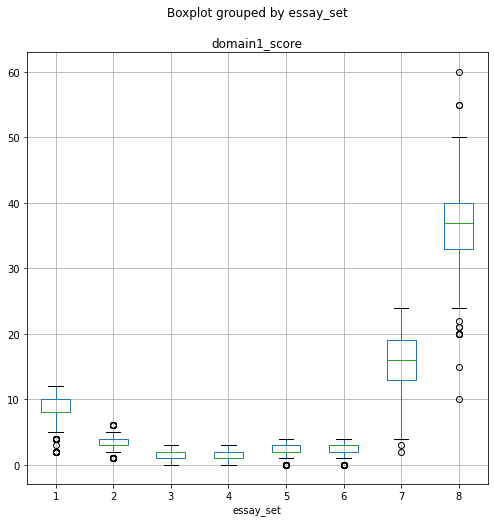

In [7]:
data = pd.read_csv('drive/My Drive/IR/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
data.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (8, 8))

In [8]:
labels = data['essay_set'].value_counts().index
values = data['essay_set'].value_counts().values
colors = data['essay_set']
fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                              marker = dict(colors = colors, line=dict(color='#000000', width=2)), 
                              title = "Distribution of sets of essay")])

fig.show()


data1 = data[['essay_set','domain1_score']]
data_count = data1.groupby(['essay_set','domain1_score'])['domain1_score'].count()
data_count.head(20)

essay_set  domain1_score
1          2                 10
           3                  1
           4                 17
           5                 17
           6                110
           7                135
           8                687
           9                334
           10               316
           11               109
           12                47
2          1                 24
           2                153
           3                763
           4                778
           5                 75
           6                  7
3          0                 39
           1                607
           2                657
Name: domain1_score, dtype: int64

In [9]:
low_scale={1:2,2:1,3:0,4:0,5:0,6:0,7:0,8:0}
high_scale={1:12,2:6,3:3,4:3,5:4,6:4,7:30,8:60}
data['low_scale']=data.essay_set.map(low_scale)
data['high_scale']=data.essay_set.map(high_scale)
data['scaled_score']=(data.domain1_score-data.low_scale)/(data.high_scale-data.low_scale)

In [10]:
data_X=data.essay.values
data_y=data.scaled_score.values.reshape(-1,1)
data_y_origin=data.domain1_score.values.reshape(-1,1)
essay_set=data.essay_set.values.reshape(-1,1)

training_X, test_X, training_y, test_y, training_y_origin, test_y_origin, training_essay_set, test_essay_set = train_test_split(data_X, data_y, data_y_origin, essay_set, test_size = 0.2, random_state = 295, stratify=data.essay_set)
train_X, valid_X, train_y, valid_y, train_y_origin, valid_y_origin, train_essay_set, valid_essay_set = train_test_split(training_X, training_y, training_y_origin, training_essay_set, test_size = 0.2, random_state = 295, stratify=training_essay_set)

train_data=(train_X,train_y)
test_data=(test_X,test_y)
valid_data=(valid_X,valid_y)

In [11]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
train_X = tokenizer.batch_encode_plus(
                      train_X,
                      return_tensors='tf',
                      add_special_tokens = True, 
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )
test_X = tokenizer.batch_encode_plus(
                      test_X,
                      return_tensors='tf',
                      add_special_tokens = True, # add [CLS], [SEP]
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )
valid_X = tokenizer.batch_encode_plus(
                      valid_X,
                      return_tensors='tf',
                      add_special_tokens = True, 
                      return_token_type_ids=True,
                      padding='max_length',
                      max_length=512, # max length of the text that can go to BERT (<=512)
                      return_attention_mask = True,
                      truncation='longest_first'
                  )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
batch_size = 64
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200

train_data = tf.data.Dataset.from_tensor_slices((dict(train_X), train_y))
validation_data = tf.data.Dataset.from_tensor_slices((dict(valid_X), valid_y))
test_data = tf.data.Dataset.from_tensor_slices((dict(test_X), test_y))

train_data = train_data.batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=train_shuffle_buffer_size)

validation_data = validation_data.batch(batch_size)
validation_data = validation_data.cache().prefetch(buffer_size=validation_shuffle_buffer_size)

test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=validation_shuffle_buffer_size)

In [13]:
# Building BERT model
input_ids = layers.Input(shape=(512,), dtype=tf.int32, name = 'input_ids')
token_type_ids = layers.Input(shape=(512,), dtype=tf.int32, name = 'token_type_ids')
attention_mask = layers.Input(shape=(512,), dtype=tf.int32, name = 'attention_mask')


encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
##text_dropout=layers.Dropout(0.2)(embedding_flatten)
##bert_dense = layers.Dense(256, name="bert_dense", activation = 'relu')(text_dropout)
bert_dense = layers.Dense(1024, name="bert_dense", activation = 'relu')(embedding_flatten)
intermediate_dense = layers.Dense(512, name = "intermediate_dense", activation = 'sigmoid')(bert_dense)
output = layers.Dense(1, activation = 'sigmoid')(intermediate_dense)
inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
BERTModel = keras.Model(inputs= inputs, outputs= output,name='BERTModel')
BERTModel.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERTModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]', 

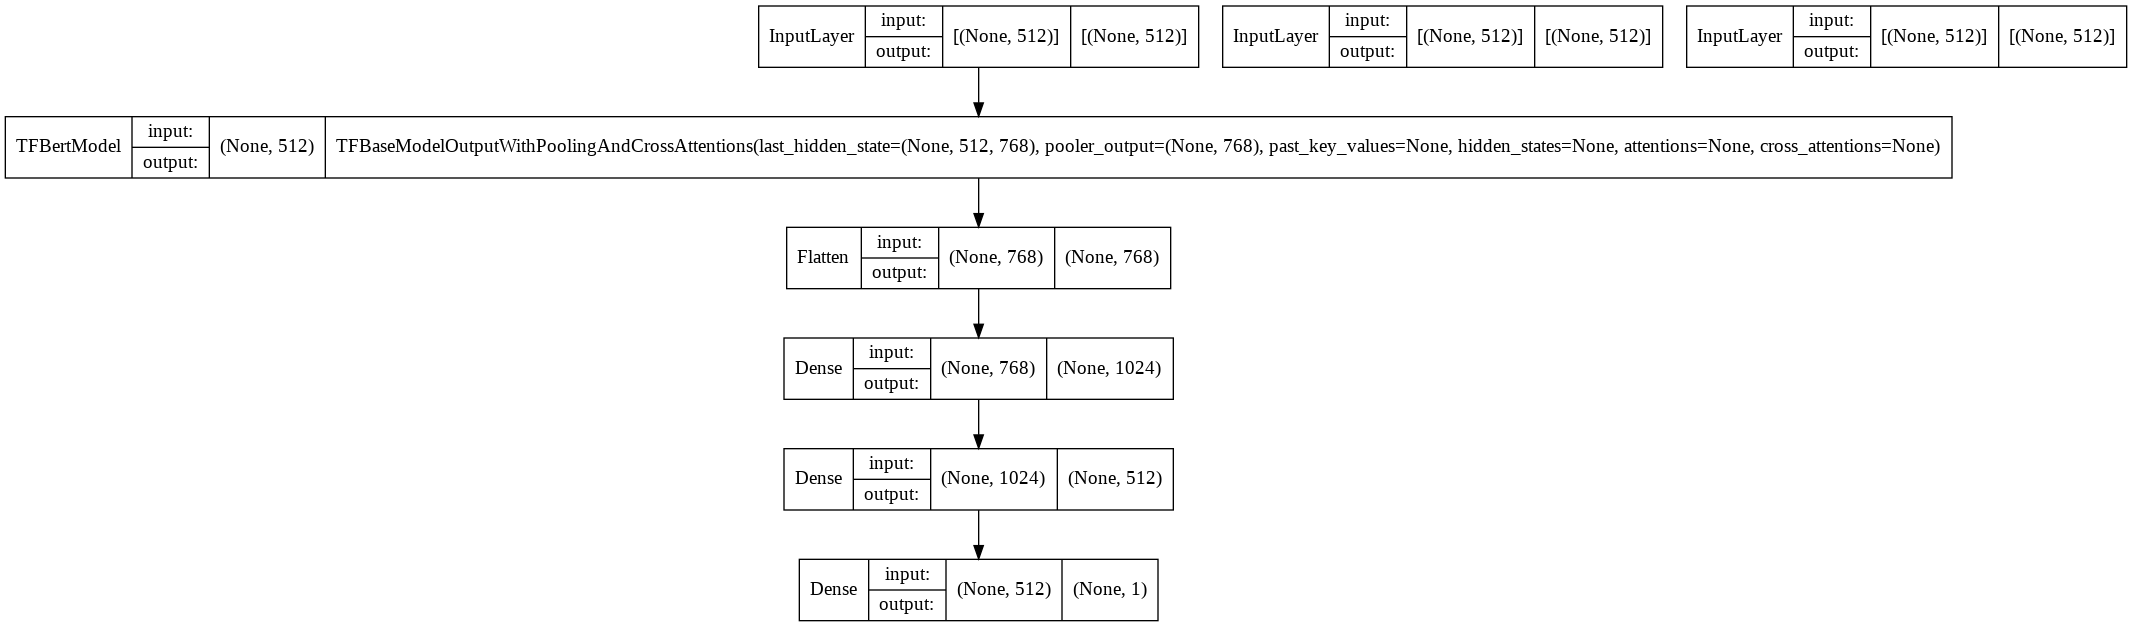

In [14]:
tf.keras.utils.plot_model(BERTModel, to_file='BERTModel.png', show_shapes=True, show_layer_names=False)

In [15]:
optimizer = optimizers.RMSprop(0.0001)
loss = losses.mean_squared_error
metrics=['mse']
BERTModel.compile(optimizer=optimizer, loss = loss, metrics = metrics)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'weights.best.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
bert_result = BERTModel.fit(train_data, validation_data = validation_data, callbacks=checkpoint, epochs = 100, verbose = 1)

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 0.0432 - mse: 0.0432
Epoch 1: val_loss improved from inf to 0.03992, saving model to weights.best.hdf5
130/130 [==============================] - 270s 2s/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.0399 - val_mse: 0.0399
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.0372 - mse: 0.0372
Epoch 2: val_loss did not improve from 0.03992
130/130 [==============================] - 254s 2s/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 0.0349 - mse: 0.0349
Epoch 3: val_loss improved from 0.03992 to 0.03062, saving model to weights.best.hdf5
130/130 [==============================] - 255s 2s/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 4/100
130/130 [==============================] - ETA: 0s - loss: 0.0339 - mse: 0.0339
Epoch 4: val_loss did not improve from 0.03062
130/

In [16]:
BERTModel.load_weights('weights.best.hdf5')


In [17]:
def QWK_bert(model):
  #calculate quadratic weighted kappa
  df=pd.DataFrame(model.predict(test_data),columns=['pred_scaled'])
  df['essay_set']=test_essay_set
  df['low_scale']=df.essay_set.map(low_scale)
  df['high_scale']=df.essay_set.map(high_scale)
  df['pred_origin']=df['pred_scaled']*(df.high_scale-df.low_scale)+df.low_scale
  df['pred_origin_rounded']=df['pred_origin'].round(0).astype(int)
  df['true_origin']=test_y_origin

  QWK=df.groupby('essay_set').apply(lambda x: cohen_kappa_score(x['pred_origin_rounded'], x['true_origin'], weights='quadratic'))
  return QWK

In [18]:
QWK_bert_result=QWK_bert(BERTModel)


In [19]:
QWK=pd.DataFrame(columns=['Essay Set Number' + str(i) for i in range(1,9)])

QWK.loc['BERT']=QWK_bert_result.values

QWK['Average QWK']=QWK.mean(axis=1)


In [20]:
QWK

,Essay Set Number1,Essay Set Number2,Essay Set Number3,Essay Set Number4,Essay Set Number5,Essay Set Number6,Essay Set Number7,Essay Set Number8,Average QWK
BERT,0.650382,0.557039,0.616673,0.764706,0.749848,0.639923,0.743066,0.570571,0.661526
